In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm

In [2]:
from scipy.special import gamma
from math import pi


def getS50(ne: np.ndarray, s: np.ndarray):
    """Get S50 from NKG function.

    Input:
        ne: Ne of Event.
        s: age of Event.

    Output:
        S50
    """
    rm = 130.0
    r = 50.0
    nr = ne / (rm * rm)
    gg1 = gamma(4.5 - s)
    gg2 = 2 * pi * gamma(s) * gamma(4.5 - 2 * s)
    rr1 = pow(r / rm, s - 2)
    rr2 = pow(1 + r / rm, s - 4.5)
    return nr * gg1 / gg2 * rr1 * rr2

In [3]:
data = np.load(f"/cxtmp/hky/ICRCdata/cosmic_gamma_test_with_dgl.npz")
data = {key: data[key] for key in data}

In [4]:
data["S50"] = getS50(data["ne"], data["age"])
data["prie"] = np.log10(data["prie"] / 1000)
data["S50"] = np.log10(data["S50"])
data["ne"] = np.log10(data["ne"])
data["sumpf"] = np.log10(data["sumpf"])
# data["pritheta"] = np.rad2deg(data["pritheta"])
# data["deltatheta"] = data["theta"] - data["pritheta"]

# data["priphi"] = 180 - np.rad2deg(data["priphi"])
# data["priphi"][data["priphi"] > 180] = data["priphi"][data["priphi"] > 180] - 360
# data["deltaphi"] = data["phi"] - data["priphi"]
# data["deltaphi"][data["deltaphi"] < -180] += 360
# data["deltaphi"][data["deltaphi"] > 180] -= 360

# data["GIN_theta"] = np.rad2deg(data["GIN_theta"])
# data["deltaGIN_theta"] = data["GIN_theta"] - data["pritheta"]
# data["GIN_phi"] = 180 - np.rad2deg(data["GIN_phi"])
# data["GIN_phi"][data["GIN_phi"] > 180] = data["GIN_phi"][data["GIN_phi"] > 180] - 360
# data["deltaGIN_phi"] = data["GIN_phi"] - data["priphi"]
# data["deltaGIN_phi"][data["deltaGIN_phi"] < -180] += 360
# data["deltaGIN_phi"][data["deltaGIN_phi"] > 180] -= 360

In [5]:
train_index, test_index = train_test_split(
    range(len(data["S50"])), random_state=42, test_size=0.6
)

In [6]:
label = "isgamma"
columns_need = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
    "GIN_isgamma",
]
columns_need.append(label)
train_data = pd.DataFrame({key: data[key][train_index] for key in columns_need})
# predictor_isgamma = TabularPredictor(
#     label=label,
#     path=f"./ag_model/{label}_with_GIN_0.6test",
# ).fit(train_data, num_cpus=40, num_gpus=2)
predictor_isgamma = TabularPredictor.load(f"./ag_model/{label}_with_GIN_0.6test")

In [7]:
label = "isgamma"
columns_need = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
#     "GIN_isgamma",
]
columns_need.append(label)
# train_data = pd.DataFrame({key: data[key][train_index] for key in columns_need})
# predictor_isgamma_withoutGIN = TabularPredictor(
#     label=label,
#     path=f"./ag_model/{label}_without_GIN_0.6test",
# ).fit(train_data, num_cpus=40, num_gpus=2)
predictor_isgamma_withoutGIN = TabularPredictor.load(f"./ag_model/{label}_without_GIN_0.6test")

In [8]:
label = "isgamma"
columns_need = [
    "nch",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "S50",
    "GIN_isgamma",
]
columns_need.append(label)

In [9]:
print("isgamma")
data["isgamma_ag"] = predictor_isgamma.predict_proba(
    pd.DataFrame({key: data[key] for key in columns_need})
)[1].to_numpy()
data["isgamma_ag_without_GIN"] = predictor_isgamma_withoutGIN.predict_proba(
    pd.DataFrame({key: data[key] for key in columns_need})
)[1].to_numpy()
# plt.scatter(
#     data["prie"][test_index],
#     predictor.predict(
#         pd.DataFrame({key: data[key][test_index] for key in columns_need})
#     ),
#     s=1,
# )
# plt.xlabel("prie")
# plt.ylabel("pred_e")
# plt.show()

isgamma


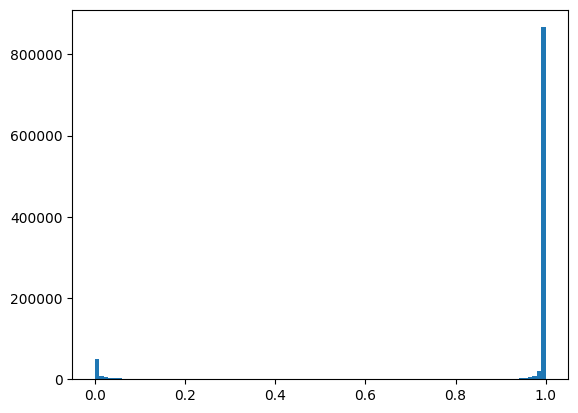

In [10]:
plt.hist(data["isgamma_ag"][test_index], bins=np.linspace(0, 1, 101))
plt.show()

In [11]:
sumpf_bins = np.linspace(1.6, 4.2, 9)
Cosmic_exclude_baseline = np.zeros(8)
gamma_reserve_baseline = np.zeros(8)
for i in range(len(sumpf_bins) - 1):
    need_baseline_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (
            (data["summd"][test_index] < 0.4)
            | (data["summd"][test_index] < (10**data["sumpf"][test_index]) ** 1.2 * 2.1e-3)
        )
        & (data["isgamma"][test_index] == 0)
    )
    need_All_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 0)
    )
    need_baseline_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (
            (data["summd"][test_index] < 0.4)
            | (data["summd"][test_index] < (10**data["sumpf"][test_index]) ** 1.2 * 2.1e-3)
        )
        & (data["isgamma"][test_index] == 1)
    )
    need_All_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 1)
    )
#     print(len(need_baseline_Cosmic[0]),len(need_All_Cosmic[0]))
    Cosmic_exclude_baseline[i] = len(need_baseline_Cosmic[0]) / len(need_All_Cosmic[0])
    gamma_reserve_baseline[i] = len(need_baseline_Gamma[0]) / len(need_All_Gamma[0])

In [55]:
prie_bins = np.linspace(1, 2.4, 8)
Cosmic_exclude_baseline = np.zeros(7)
gamma_reserve_baseline = np.zeros(7)
SNR_baseline = np.zeros(7)
for i in tqdm(range(len(prie_bins) - 1)):
    need_All_Cosmic = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma"][test_index] == 0)
    )
    need_All_Gamma = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma"][test_index] == 1)
    )
    for a in np.linspace(0.5, 2, 16):
        for b in np.logspace(-4, -2, 21):
            need_baseline_Gamma = np.where(
                (data["prie"][test_index] > prie_bins[i])
                & (data["prie"][test_index] < prie_bins[i + 1])
                & (
                    (data["summd"][test_index] < 0.4)
                    | (
                        data["summd"][test_index]
                        < (10 ** data["sumpf"][test_index]) ** a * b
                    )
                )
                & (data["isgamma"][test_index] == 1)
            )
            need_baseline_Cosmic = np.where(
                (data["prie"][test_index] > prie_bins[i])
                & (data["prie"][test_index] < prie_bins[i + 1])
                & (
                    (data["summd"][test_index] < 0.4)
                    | (
                        data["summd"][test_index]
                        < (10 ** data["sumpf"][test_index]) ** a * b
                    )
                )
                & (data["isgamma"][test_index] == 0)
            )
            this_Cosmic_exclude_baseline = len(need_baseline_Cosmic[0]) / len(need_All_Cosmic[0])
            this_gamma_reserve_baseline = len(need_baseline_Gamma[0]) / len(need_All_Gamma[0])
            this_SNR = this_gamma_reserve_baseline/np.sqrt(this_Cosmic_exclude_baseline)
            
            if this_SNR>SNR_baseline[i]:
                print(i,a,b,this_SNR)
                SNR_baseline[i] = this_SNR
                Cosmic_exclude_baseline[i] = this_Cosmic_exclude_baseline
                gamma_reserve_baseline[i] = this_gamma_reserve_baseline
    #     print(len(need_baseline_Cosmic[0]),len(need_All_Cosmic[0]))
    #     print(i)
#     Cosmic_exclude_baseline[i] = len(need_baseline_Cosmic[0]) / len(need_All_Cosmic[0])
#     gamma_reserve_baseline[i] = len(need_baseline_Gamma[0]) / len(need_All_Gamma[0])

  0%|          | 0/8 [00:00<?, ?it/s]

0 0.5 0.0001 4.488414646010071
0 0.6 0.01 4.48848721067276
0 0.7 0.00630957344480193 4.4890677279742786
0 0.7 0.01 4.495503230197713
0 1.2000000000000002 0.000630957344480193 4.499194119549271
1 0.5 0.0001 6.019664796817323
1 0.6 0.01 6.021096141880291
1 0.7 0.00630957344480193 6.026019968896899
1 0.8 0.005011872336272725 6.031368511048499
1 1.2000000000000002 0.000630957344480193 6.033649204783092
1 1.5 0.00012589254117941674 6.035381737207059
2 0.5 0.0001 8.699564027471874
2 0.6 0.00794328234724282 8.701638724901166
2 0.6 0.01 8.714945404964897
2 0.7 0.00630957344480193 8.740414104441713
2 0.7 0.00794328234724282 8.790421466616701
2 0.8 0.005011872336272725 8.805793261318483
2 0.9 0.002511886431509582 8.813028514466911
2 1.0 0.001584893192461114 8.83217456289002
2 1.3 0.00025118864315095795 8.838377733800083
3 0.5 0.0001 13.508062186939197
3 0.6 0.00630957344480193 13.511179173847324
3 0.6 0.00794328234724282 13.53251854575683
3 0.6 0.01 13.590062919445376
3 0.7 0.00630957344480193 1

/tmp/ipykernel_3464/2428597934.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  this_SNR = this_gamma_reserve_baseline/np.sqrt(this_Cosmic_exclude_baseline)


7 0.5 0.0001 inf


KeyboardInterrupt: 

In [64]:
SNR_baseline

array([ 4.49919412,  6.03538174,  8.83837773, 14.21830501, 23.67138193,
       36.41471514, 36.33993864])

In [81]:
prie_bins = np.linspace(1, 2.4, 8)
Cosmic_exclude = np.zeros(7)
gamma_reserve = np.zeros(7)
SNR = np.zeros(7)
for i in tqdm(range(len(prie_bins) - 1)):
    need_All_Cosmic = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma"][test_index] == 0)
    )
    need_All_Gamma = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma"][test_index] == 1)
    )
    for P_value in np.linspace(0.99,0.9,100):
        need_Cosmic = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma_ag"][test_index] > P_value)
        & (data["isgamma"][test_index] == 0)
    )
        need_Gamma = np.where(
        (data["prie"][test_index] > prie_bins[i])
        & (data["prie"][test_index] < prie_bins[i + 1])
        & (data["isgamma_ag"][test_index] > P_value)
        & (data["isgamma"][test_index] == 1)
    )
        this_Cosmic_exclude_baseline = len(need_Cosmic[0]) / len(need_All_Cosmic[0])
        this_gamma_reserve_baseline = len(need_Gamma[0]) / len(need_All_Gamma[0])
        this_SNR = this_gamma_reserve_baseline/np.sqrt(this_Cosmic_exclude_baseline)
        if not np.isinf(this_SNR):
            if this_SNR>SNR[i]:
                print(i,P_value,this_SNR)
                SNR[i] = this_SNR
                Cosmic_exclude[i] = this_Cosmic_exclude_baseline
                gamma_reserve[i] = this_gamma_reserve_baseline
            else:
                break
    #     print(len(need_baseline_Cosmic[0]),len(need_All_Cosmic[0]))
    #     print(i)
#     Cosmic_exclude_baseline[i] = len(need_baseline_Cosmic[0]) / len(need_All_Cosmic[0])
#     gamma_reserve_baseline[i] = len(need_baseline_Gamma[0]) / len(need_All_Gamma[0])

  0%|          | 0/7 [00:00<?, ?it/s]

0 0.99 6.892659419901356
1 0.99 11.678457257405988
2 0.99 17.104868599078614
3 0.99 28.120087352173353
3 0.9890909090909091 28.190225833309974
4 0.99 34.789230311749826
4 0.9890909090909091 34.84746551530204
5 0.99 48.179683606819424
5 0.9890909090909091 48.235681923292255
5 0.9881818181818182 48.29537824179632
5 0.9872727272727273 48.34503712621564
5 0.9863636363636363 48.3925828666171
5 0.9854545454545455 48.432204316951655
5 0.9845454545454545 48.46442976322376
5 0.9836363636363636 48.492428921460174
5 0.9827272727272727 48.5204280796966
5 0.9818181818181818 48.54578580791071
5 0.980909090909091 48.57325668014267


/tmp/ipykernel_3464/3936142116.py:31: RuntimeWarning: divide by zero encountered in double_scalars
  this_SNR = this_gamma_reserve_baseline/np.sqrt(this_Cosmic_exclude_baseline)


6 0.9845454545454545 74.00578525775204
6 0.9836363636363636 74.04948218323464
6 0.9827272727272727 74.09654041067748
6 0.9818181818181818 74.13015343027948
6 0.980909090909091 74.15928471393457
6 0.98 74.19401816752331
6 0.9790909090909091 74.22875162111205
6 0.9781818181818182 74.25900333875387
6 0.9772727272727273 74.28253245247528
6 0.9763636363636363 74.30270026423648
6 0.9754545454545455 74.32734981194463
6 0.9745454545454545 74.34863805769257
6 0.9736363636363636 74.37216717141398
6 0.9727272727272728 74.39457585114866
6 0.9718181818181818 74.41362322892313
6 0.9709090909090909 74.43379104068434
6 0.97 74.4494771164986
6 0.9690909090909091 74.47412666420675
6 0.9681818181818181 74.48981274002102
6 0.9672727272727273 74.50998055178223
6 0.9663636363636363 74.52342575962304
6 0.9654545454545455 74.53911183543731
6 0.9645454545454546 74.55479791125158
6 0.9636363636363636 74.56264094915872
6 0.9627272727272728 74.56936355307913


In [82]:
prie_center = (prie_bins[:-1]+prie_bins[1:])/2

(10, 280)

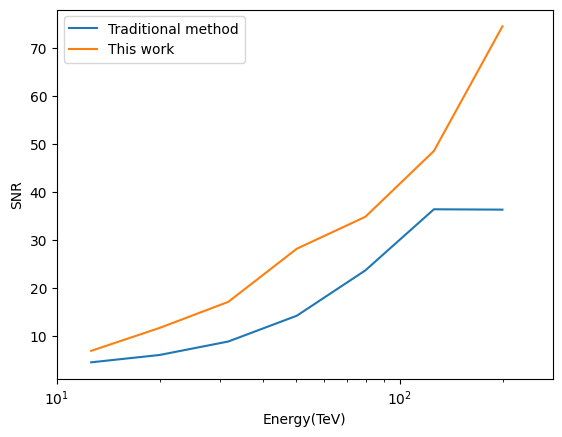

In [86]:
plt.plot(10**prie_center,SNR_baseline,label="Traditional method")
plt.plot(10**prie_center,SNR,label="This work")
plt.xlabel("Energy(TeV)")
plt.ylabel("SNR")
plt.xscale("log")
plt.legend()
plt.xlim(10,280)

In [87]:
Cosmic_exclude

array([0.01599514, 0.00603774, 0.00301299, 0.00116693, 0.00077953,
       0.00041064, 0.00017655])

In [88]:
Cosmic_exclude_baseline

array([0.03786192, 0.02103774, 0.00935283, 0.00367583, 0.00120473,
       0.00051329, 0.00052966])

In [89]:
gamma_reserve

array([0.87172771, 0.90744963, 0.93889893, 0.96298786, 0.97294579,
       0.98429538, 0.99082924])

In [90]:
gamma_reserve_baseline

array([0.87545942, 0.87539537, 0.85475997, 0.86203592, 0.82161655,
       0.82501178, 0.83634063])

(10, 280)

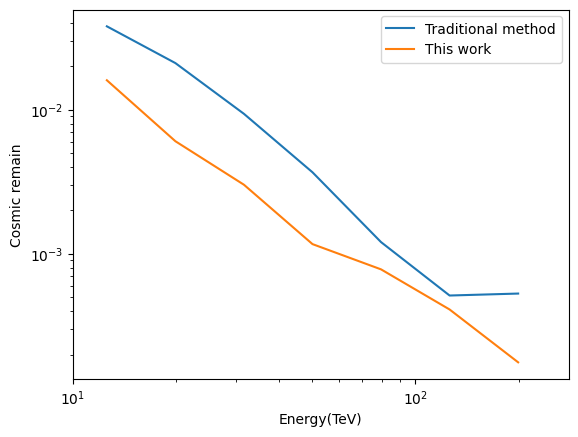

In [96]:
plt.plot(10**prie_center,Cosmic_exclude_baseline,label="Traditional method")
plt.plot(10**prie_center,Cosmic_exclude,label="This work")
plt.xlabel("Energy(TeV)")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Cosmic remain")
plt.legend()
plt.xlim(10,280)

(10, 280)

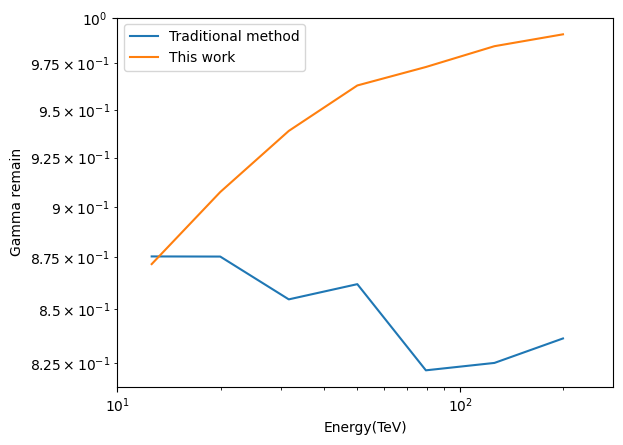

In [97]:
plt.plot(10**prie_center,gamma_reserve_baseline,label="Traditional method")
plt.plot(10**prie_center,gamma_reserve,label="This work")
plt.xlabel("Energy(TeV)")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Gamma remain")
plt.legend()
plt.xlim(10,280)

In [41]:
prie_bins

array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6])

In [42]:
1-Cosmic_exclude_baseline

array([0.94756023, 0.96613208, 0.98123156, 0.99089795, 0.99539366,
       0.99692023, 0.99735169, 0.99933972])

In [44]:
gamma_reserve_baseline/np.sqrt(Cosmic_exclude_baseline)

array([ 4.02378938,  5.04154933,  6.79735874,  9.79168206, 13.72281228,
       16.71078153, 17.93917126, 35.7275978 ])

In [39]:
np.max(data["prie"])

4.998421793472894

In [12]:
gamma_reserve_baseline

array([0.92945295, 0.91774798, 0.92061425, 0.93490082, 0.94223613,
       0.94055013, 0.93281816, 0.92253575])

In [13]:
Cosmic_exclude = np.zeros(8)
gamma_reserve = np.zeros(8)
for i in range(len(sumpf_bins) - 1):
    need_All_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 0)
    )

    need_All_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 1)
    )
    tmp = data["isgamma_ag"][test_index][need_All_Gamma]
    tmp.sort()
    P_value = tmp[int((1-gamma_reserve_baseline[i])*len(tmp))]
    need_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma_ag"][test_index] > P_value)
        & (data["isgamma"][test_index] == 0)
    )
    need_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma_ag"][test_index] > P_value)
        & (data["isgamma"][test_index] == 1)
    )

    Cosmic_exclude[i] = len(need_Cosmic[0]) / len(need_All_Cosmic[0])
    gamma_reserve[i] = len(need_Gamma[0]) / len(need_All_Gamma[0])

In [14]:
Cosmic_exclude_without_GIN = np.zeros(8)
gamma_reserve_without_GIN = np.zeros(8)
for i in range(len(sumpf_bins) - 1):
    need_All_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 0)
    )

    need_All_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma"][test_index] == 1)
    )
    tmp = data["isgamma_ag_without_GIN"][test_index][need_All_Gamma]
    tmp.sort()
    P_value = tmp[int((1-gamma_reserve_baseline[i])*len(tmp))]
    print(P_value)
    need_Cosmic = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma_ag_without_GIN"][test_index] > P_value)
        & (data["isgamma"][test_index] == 0)
    )
    need_Gamma = np.where(
        (data["sumpf"][test_index] > sumpf_bins[i])
        & (data["sumpf"][test_index] < sumpf_bins[i + 1])
        & (data["isgamma_ag_without_GIN"][test_index] > P_value)
        & (data["isgamma"][test_index] == 1)
    )

    Cosmic_exclude_without_GIN[i] = len(need_Cosmic[0]) / len(need_All_Cosmic[0])
    gamma_reserve_without_GIN[i] = len(need_Gamma[0]) / len(need_All_Gamma[0])

0.9632916450500488
0.9747394919395447
0.9881224632263184
0.994131863117218
0.9964087009429932
0.998040497303009
0.9990476369857788
0.9999865889549255


In [15]:
gamma_reserve_baseline

array([0.92945295, 0.91774798, 0.92061425, 0.93490082, 0.94223613,
       0.94055013, 0.93281816, 0.92253575])

In [16]:
gamma_reserve

array([0.92936543, 0.91774306, 0.92061083, 0.93490082, 0.94219974,
       0.94055013, 0.93243525, 0.92100635])

In [17]:
gamma_reserve_without_GIN

array([0.92936543, 0.91774306, 0.92061083, 0.93490082, 0.94222703,
       0.94055013, 0.93194793, 0.92245928])

In [18]:
Cosmic_exclude_baseline

array([0.03114754, 0.02305244, 0.01457033, 0.00911476, 0.00549551,
       0.00230017, 0.        , 0.        ])

In [19]:
(0.00549551-0.00018318)/0.00549551

0.9666673338780205

In [20]:
Cosmic_exclude

array([0.01803279, 0.00784051, 0.0019955 , 0.00062146, 0.00018318,
       0.        , 0.        , 0.        ])

In [21]:
Cosmic_exclude_without_GIN

array([0.03114754, 0.01889764, 0.00817206, 0.00414307, 0.0010991 ,
       0.00057504, 0.        , 0.        ])

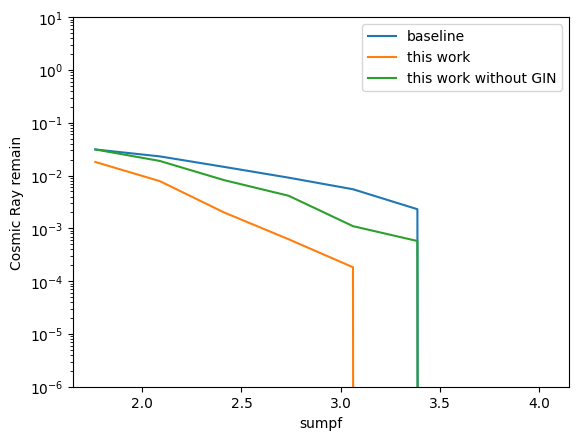

In [22]:
x = (sumpf_bins[:-1] + sumpf_bins[1:]) / 2
plt.plot(x, Cosmic_exclude_baseline, label="baseline")
plt.plot(x, Cosmic_exclude, label="this work")
plt.plot(x, Cosmic_exclude_without_GIN, label="this work without GIN")
plt.legend()
plt.yscale("log")
plt.ylim(1e-6,10)
plt.ylabel("Cosmic Ray remain")
plt.xlabel("sumpf")
plt.show()